In [29]:
import pandas as pd
import ixmp as ix
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [30]:
mp = ix.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at 'C:\Users\ga46gup\.local\ixmp\localdb\default'


In [31]:
base = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scen='carbon_tax')

In [32]:
model = 'Westeros Electrified'
scen = base.clone(model, 'flexibile_generation','testing new formulation', keep_sol=False)
scen.check_out()

vintage_years, act_years = scen.vintage_and_active_years()
model_horizon = scen.set('year')
country = 'Westeros'

## add Renewbale Formulation

## Describing the Renewable Technologies  Flexibility 
### flexibility of demand and supply --> ensuring the activity flexibility reserve 

The wind power plant has a flexibility demand of 5% of its ACT. The coal powerplant can provide 20% of it's activity as flexibility.

In [33]:
base_flexibility_factor = pd.DataFrame({
        'node_loc': country,
        'commodity': 'electricity',
        'level' : 'secondary',
        'mode': 'standard',
        'unit': '???',
        'time': 'year',
        'year_vtg': vintage_years,
        'year_act': act_years,
})

base_rating = pd.DataFrame({
        'node': country,
        'commodity': 'electricity',
        'level' : 'secondary', 
        'unit': '???',
        'time': 'year',
        'year_act': model_horizon})

In [34]:
# add the ratings as a set 
scen.add_set('rating', ['r1', 'r2'])

# For the Load 
flexibility_factor = make_df(base_flexibility_factor, technology= 'grid', rating= 'unrated', value = -0.1)
scen.add_par('flexibility_factor',flexibility_factor)

# For the Wind PPL
rating_bin = make_df(base_rating, technology= 'wind_ppl', value = 0.2, rating= 'r1')
scen.add_par('rating_bin', rating_bin)

flexibility_factor = make_df(base_flexibility_factor, technology= 'wind_ppl', rating= 'r1', value = -0.2)
scen.add_par('flexibility_factor',flexibility_factor)

rating_bin = make_df(base_rating, technology= 'wind_ppl', value = 0.8, rating= 'r2')
scen.add_par('rating_bin', rating_bin)

flexibility_factor = make_df(base_flexibility_factor, technology= 'wind_ppl', rating= 'r2', value = -0.7)
scen.add_par('flexibility_factor',flexibility_factor)

# For the Coal PPL
flexibility_factor = make_df(base_flexibility_factor, technology= 'coal_ppl', rating= 'unrated', value = 1)
scen.add_par('flexibility_factor',flexibility_factor)


### commit and solve

In [35]:
scen.commit(comment='define parameters for renewable implementation')
scen.set_as_default()

In [36]:
scen.solve()

In [37]:
scen.var('OBJ')['lvl']

667938.4375

### plotting

In [38]:
from tools import Plots
p = Plots(scen, country, firstyear=700)

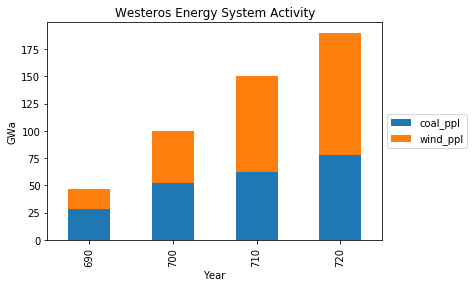

In [39]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

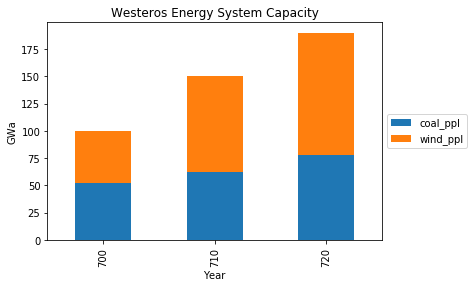

In [40]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

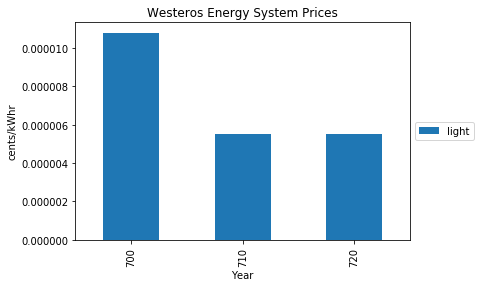

In [41]:
p.plot_prices(subset=['light'], baseyear=True)

In [42]:
mp.close_db()